## 1. Setup

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import tifffile as tiff
import geopandas as gpd
from shapely.geometry import Polygon, LineString

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
!pwd

/kaggle/working


In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [4]:
data_dir = os.path.join("/kaggle", "input", "sp8-german")
train_dir = os.path.join(data_dir, "train") 
train_images = os.path.join(train_dir, "image")
train_masks = os.path.join(train_dir, "mask")
val_dir = os.path.join(data_dir, "val")
val_images = os.path.join(val_dir, "image")
val_masks = os.path.join(val_dir, "mask")
train_fns = sorted(os.listdir(train_images))
train_msks = sorted(os.listdir(train_masks))
val_fns = sorted(os.listdir(val_images))
val_msks = sorted(os.listdir(val_masks))
print(len(train_fns), len(val_fns))

176 26


## 2. Analyze data

/kaggle/input/sp8-german/train/image/Germany_0_15_65.png


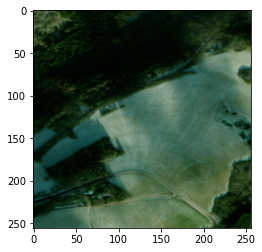

In [5]:
sample_image_fp = os.path.join(train_images, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [6]:
print(os.path.join(train_masks, train_msks[0]))

/kaggle/input/sp8-german/train/mask/Germany_0_15_65.npy


In [7]:
def convert_mask_to_rgb(mask):
    color_map = {0: (255, 0, 0),  # Red for label 0
              1: (0, 255, 0),  # Green for label 1
              2: (0, 0, 255)}  # Blue for label 2
    label_rgb = np.array([color_map[val] for val in label.flat], dtype=np.uint8).reshape(label.shape + (3,))
    return label_rgb

(256, 256, 3)
0 181 0 1


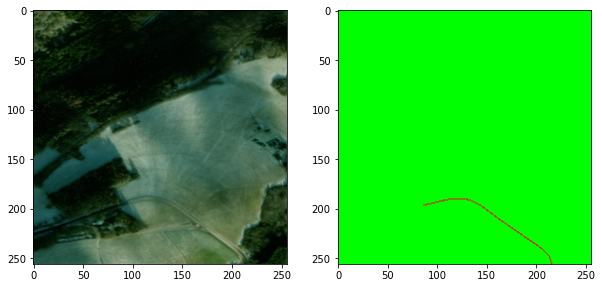

In [8]:
cityscape = np.array(sample_image)
print(cityscape.shape)
label = np.load(os.path.join(train_masks, train_msks[0]))
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(convert_mask_to_rgb(label))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## 3. Define Labels

In [9]:
num_classes = 3

In [10]:
from collections import Counter

class_counts = Counter()
for label in train_msks:
    array = np.load(os.path.join(train_masks, label))
    class_counts.update(array.flatten())
total_pixels = sum(class_counts.values())
class_weights = {cls: total_pixels / count for cls, count in class_counts.items()}
weight_tensor = torch.tensor([class_weights[0], class_weights[1], class_weights[2]], dtype=torch.float).to(device)
print(weight_tensor)

tensor([77.9310,  1.0290, 65.0680], device='cuda:0')


## 4. Define Dataset

In [11]:
class SP8(Dataset):
    
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.image_fns = sorted(os.listdir(image_dir))
        self.label_dir = label_dir
        self.label_msks = sorted(os.listdir(label_dir))
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        label_msk = self.label_msks[index]
        label_fp = os.path.join(self.label_dir, label_msk)
        label = np.load(label_fp)
#         cityscape, label = self.split_image(image)
#         label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        image = self.transform(image)
        label = torch.Tensor(label).long()
        return image, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [12]:
dataset = SP8(train_images, train_masks)
print(len(dataset))

176


In [13]:
image, label = dataset[0]
print(image.shape, label.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## 5. Define Model

In [14]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [15]:
model = UNet(num_classes=num_classes)

In [16]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

176 44
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [17]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 3, 256, 256])


## 6. Train the model

In [18]:
batch_size = 4

epochs = 35
lr = 0.001

In [19]:
dataset = SP8(train_images, train_masks)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [20]:
model = UNet(num_classes=num_classes).to(device)

In [21]:
criterion = nn.CrossEntropyLoss(weight = weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [22]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    print(f"Epoch: {epoch+1}/{epochs} | Epoch Loss: {epoch_loss/len(data_loader):.4f}")
    epoch_losses.append(epoch_loss/len(data_loader))

Epoch: 1/35 | Epoch Loss: 0.9492


Epoch: 2/35 | Epoch Loss: 0.8454


Epoch: 3/35 | Epoch Loss: 0.7500


Epoch: 4/35 | Epoch Loss: 0.6938


Epoch: 5/35 | Epoch Loss: 0.6662


Epoch: 6/35 | Epoch Loss: 0.6473


Epoch: 7/35 | Epoch Loss: 0.6198


Epoch: 8/35 | Epoch Loss: 0.6028


Epoch: 9/35 | Epoch Loss: 0.5704


Epoch: 10/35 | Epoch Loss: 0.5606


Epoch: 11/35 | Epoch Loss: 0.5534


Epoch: 12/35 | Epoch Loss: 0.5413


Epoch: 13/35 | Epoch Loss: 0.5358


Epoch: 14/35 | Epoch Loss: 0.5191


Epoch: 15/35 | Epoch Loss: 0.5049


Epoch: 16/35 | Epoch Loss: 0.5010


Epoch: 17/35 | Epoch Loss: 0.4980


Epoch: 18/35 | Epoch Loss: 0.4815


Epoch: 19/35 | Epoch Loss: 0.4774


Epoch: 20/35 | Epoch Loss: 0.4665


Epoch: 21/35 | Epoch Loss: 0.4679


Epoch: 22/35 | Epoch Loss: 0.4490


Epoch: 23/35 | Epoch Loss: 0.4375


Epoch: 24/35 | Epoch Loss: 0.4366


Epoch: 25/35 | Epoch Loss: 0.4278


Epoch: 26/35 | Epoch Loss: 0.4166


Epoch: 27/35 | Epoch Loss: 0.4106


Epoch: 28/35 | Epoch Loss: 0.4035


Epoch: 29/35 | Epoch Loss: 0.3955


Epoch: 30/35 | Epoch Loss: 0.3844


Epoch: 31/35 | Epoch Loss: 0.3882


Epoch: 32/35 | Epoch Loss: 0.3858


Epoch: 33/35 | Epoch Loss: 0.3770


Epoch: 34/35 | Epoch Loss: 0.3637


Epoch: 35/35 | Epoch Loss: 0.3564



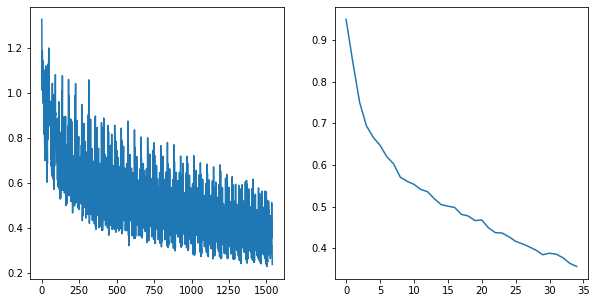

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [24]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

## 7. Check model predictions

In [25]:
model_path = "/kaggle/working/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
test_batch_size = 8
dataset = SP8(val_images, val_masks)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [27]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


In [28]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

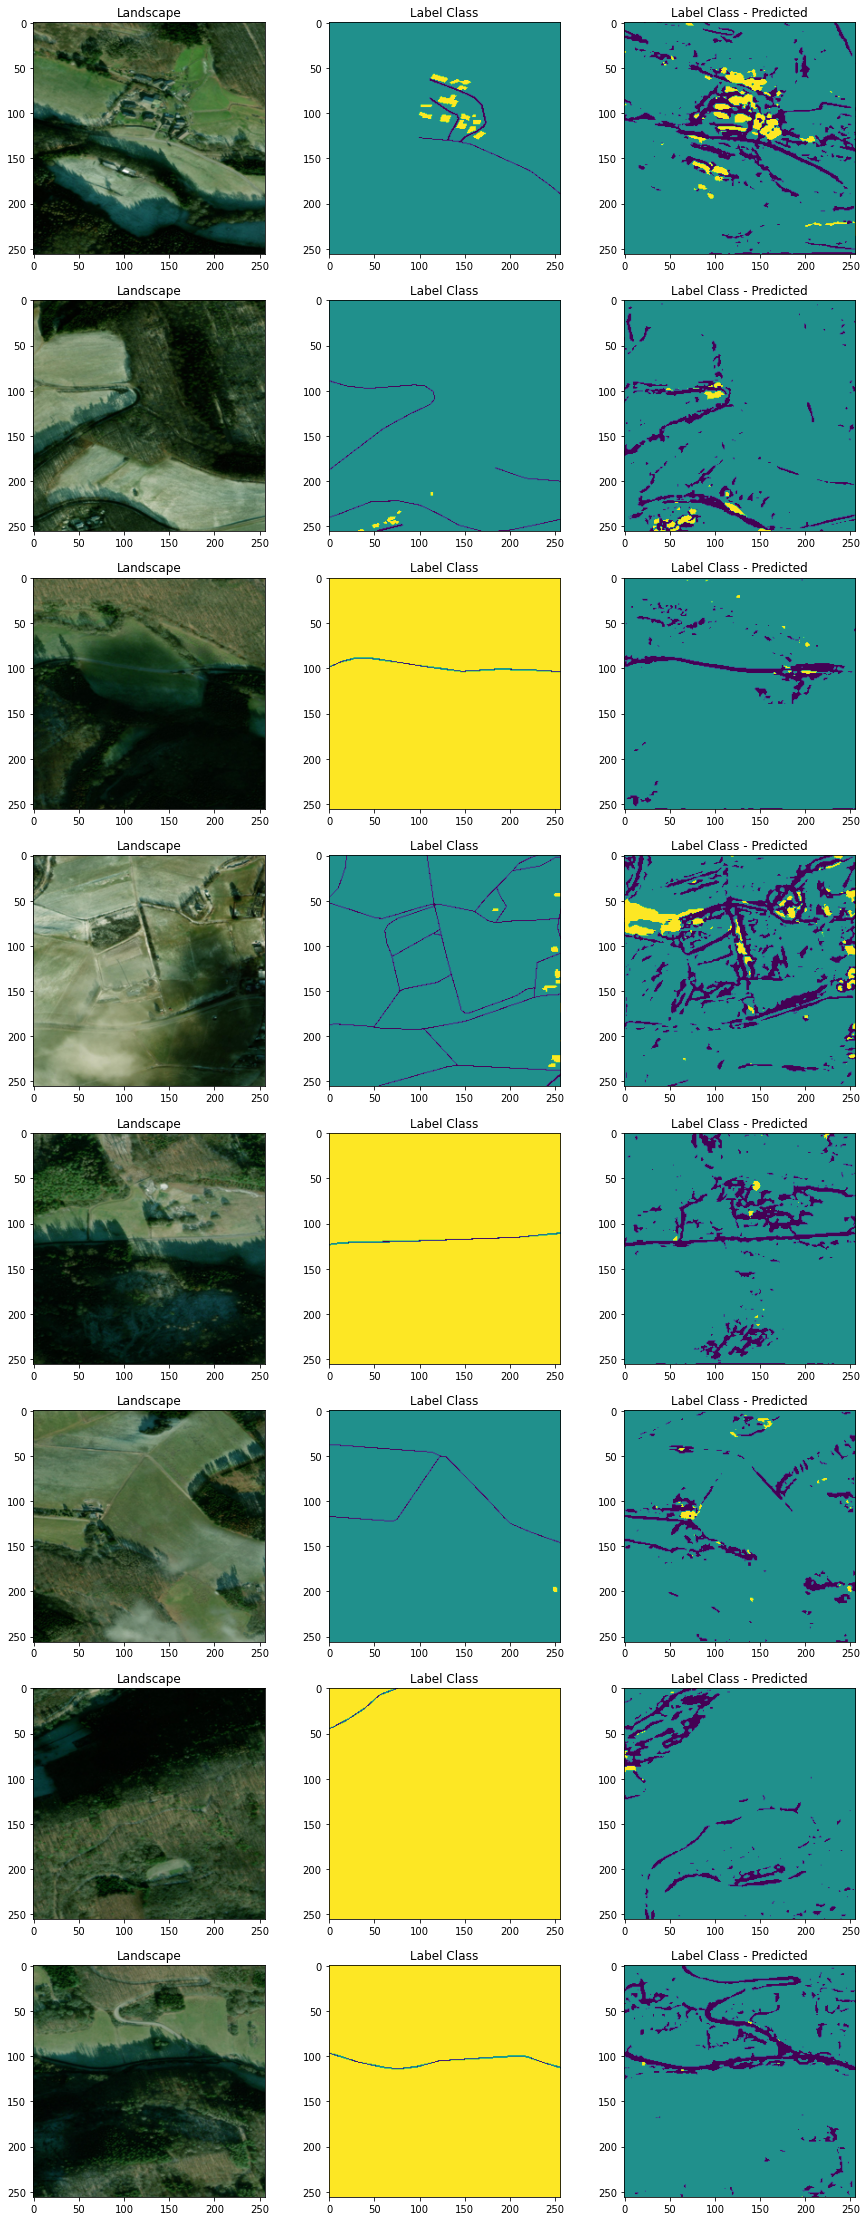

In [29]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")